In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random

random.seed(42)

def load_data(fpath, dropna=True):
    df = pd.read_csv(fpath)
    if dropna:
        df = df.dropna()
    df = df[['Date', 'Close']]
    df['Month'] = df['Date'].map(lambda x: int(x.split('/')[0]))
    df['Day'] = df['Date'].map(lambda x: int(x.split('/')[1]))

    df['Month_sin'] = np.sin((df.Month-1)*(2*np.pi/12))
    df['Month_cos'] = np.cos((df.Month-1)*(2*np.pi/12))

    df['Day_sin'] = np.sin((df.Day-1)*(2*np.pi/31))
    df['Day_cos'] = np.cos((df.Day-1)*(2*np.pi/31))
    return df

def add_features(df):
    df['3day MA'] = df['Close'].rolling(window = 3).mean()
    df['10day MA'] = df['Close'].rolling(window = 10).mean()
    df['30day MA'] = df['Close'].rolling(window = 30).mean()
    df['Std_dev']= df['Close'].rolling(5).std()
    
    df = df.dropna()
    return df


In [2]:
company_files = ['BAYZF.csv', 'HON.csv', 'MMM.csv', 'SYF.csv']
fpath = './Data Given/' + company_files[0]
df = load_data(fpath)
df = add_features(df)
print(df.head(5))

         Date      Close  Month  Day  Month_sin     Month_cos   Day_sin  \
29  3/27/2009  49.650002      3   27   0.866025  5.000000e-01 -0.848644   
30  3/30/2009  47.549999      3   30   0.866025  5.000000e-01 -0.394356   
31  3/31/2009  47.450001      3   31   0.866025  5.000000e-01 -0.201299   
32   4/1/2009  47.450001      4    1   1.000000  6.123234e-17  0.000000   
33   4/2/2009  49.000000      4    2   1.000000  6.123234e-17  0.201299   

     Day_cos    3day MA  10day MA   30day MA   Std_dev  
29  0.528964  51.316667    48.972  49.129666  1.190495  
30  0.918958  49.750000    48.992  48.863000  2.192414  
31  0.979530  48.216667    49.407  48.671333  2.327659  
32  1.000000  47.483334    49.697  48.476333  2.030271  
33  0.979530  47.966667    49.972  48.318000  1.035375  


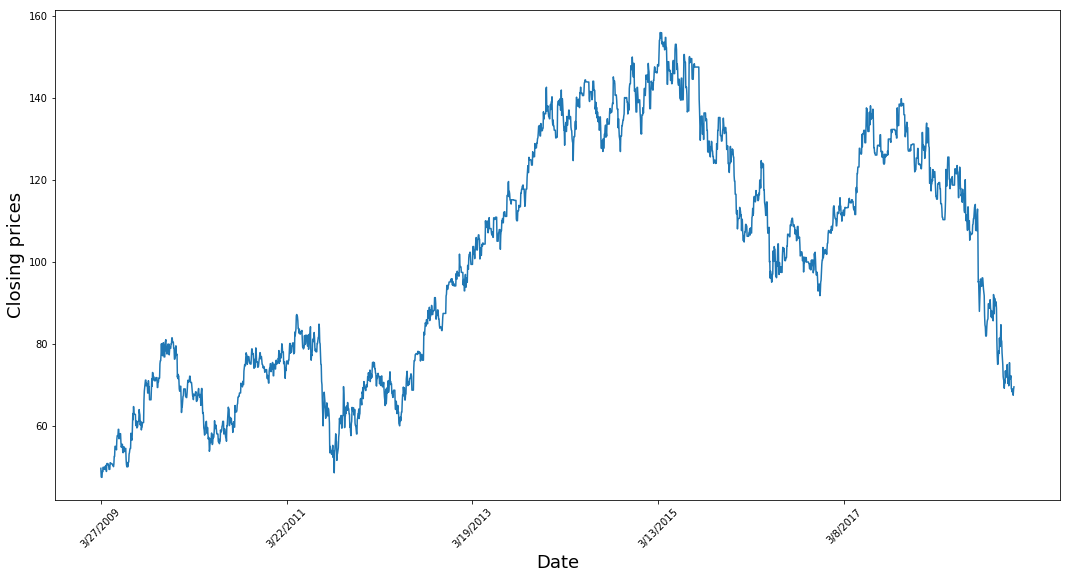

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), df['Close'])
plt.xticks(range(0,df.shape[0],500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing prices', fontsize=18)
plt.show()

In [4]:
input_features = df[['Close', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', '3day MA', '10day MA', '30day MA', 'Std_dev']].loc[:].values

split_idx = int(0.9*len(input_features))
train_data = input_features[:split_idx]
test_data = input_features[split_idx:]

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(train_data)
test_set_scaled = sc.transform(test_data)


In [5]:
def get_X_Y_train(training_set_scaled, chunk_size=45):
    X_train = []
    Y_train = []

    for i in range(chunk_size, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-chunk_size:i])
        Y_train.append(training_set_scaled[i, 0])

    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    return X_train, Y_train


In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def fit_model(X_train, Y_train, epochs=3):
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 50, return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.4))

    model.add(Dense(units=1))

    # Could experiment using root_mean_squared error
    model.compile(optimizer='adam', loss="mean_squared_error")

    model.fit(X_train, Y_train, epochs=epochs, batch_size=32)
    return model
          

/home/foobar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
X_train, Y_train = get_X_Y_train(training_set_scaled)
model = fit_model(X_train, Y_train)

Epoch 1/3
2167/2167 [==============================] - 21s 10ms/step - loss: 0.0252
Epoch 2/3
2167/2167 [==============================] - 20s 9ms/step - loss: 0.0100
Epoch 3/3
2167/2167 [==============================] - 16s 8ms/step - loss: 0.0083


In [8]:
def predict_stock_prices(total_data, chunk_size, num_days, num_trailing_blanks, sc, model):
    predicted_stock_prices = []

    for day in range(num_days):
        curr_idx = len(total_data) - num_trailing_blanks + day

        start_idx = len(total_data) - num_trailing_blanks - chunk_size + day
        end_idx = start_idx+chunk_size
        inputs = total_data[start_idx:end_idx]
        X_test = []
        X_test.append(inputs)

        X_test = np.array(X_test)
        predicted_stock_price = model.predict(X_test)
        
        total_data[curr_idx][0] = predicted_stock_price
        total_data[curr_idx][5] = total_data[curr_idx-2:curr_idx+1, 0].mean()
        total_data[curr_idx][6] = total_data[curr_idx-9:curr_idx+1, 0].mean()
        total_data[curr_idx][7] = total_data[curr_idx-29:curr_idx+1, 0].mean()
        total_data[curr_idx][8] = total_data[curr_idx-4:curr_idx+1, 0].std()


        predicted_stock_price = sc.inverse_transform(total_data[curr_idx].reshape(1, -1))[0][0]
        predicted_stock_prices.append(predicted_stock_price)
        
    return predicted_stock_prices

In [9]:
num_days = 50
chunk_size = 45
total_data = np.concatenate((training_set_scaled, test_set_scaled))
predicted_stock_prices = predict_stock_prices(total_data, chunk_size, num_days, len(test_set_scaled), sc=sc, model=model)

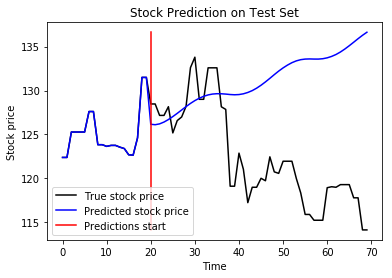

[126.16175454192407, 126.11035614306128, 126.20671118042654, 126.41466309336163, 126.69857867385542, 127.03638019357182, 127.40276581342256, 127.78416713144517, 128.17058229705012, 128.53319460892655, 128.85389348102635, 129.12420189269488, 129.34002347876825, 129.4998592538867, 129.59708654566384, 129.63745577207422, 129.6291725857333, 129.5938430514804, 129.54270309836932, 129.5155533721567, 129.53993126768268, 129.62657520592904, 129.77708108941235, 129.9879146724785, 130.26599584012843, 130.60090922856992, 130.97895721296464, 131.38483980481394, 131.8052276644755, 132.20746617122626, 132.57185529764539, 132.89159792046405, 133.1643034164793, 133.37046559258408, 133.50620776250338, 133.5739593163029, 133.59006694777554, 133.57492848787166, 133.57293845558382, 133.61568538290953, 133.7163887700466, 133.87785275340056, 134.09660123761154, 134.38005161575234, 134.71742669997846, 135.09287084342515, 135.4893912379203, 135.89264414424633, 136.27659761406667, 136.62513755476482]


In [10]:
actual_line = np.concatenate((train_data[-20:, 0], test_data[:num_days, 0]))
predicted_line = np.concatenate((train_data[-20:, 0], predicted_stock_prices))

miny = min(np.min(actual_line), np.min(predicted_line))
maxy = max(np.max(actual_line), np.max(predicted_line))

plt.plot(actual_line, color='black', label='True stock price')
plt.plot(predicted_line, color='blue', label='Predicted stock price')
plt.plot((20, 20), (miny, maxy), 'k-', color='red', label='Predictions start')
plt.title("Stock Prediction on Test Set")
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()
print(predicted_stock_prices)

In [11]:
def get_2019_predictions(csv_path):
    df = load_data(csv_path)
    df = add_features(df)

    input_data = df[['Close', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', '3day MA', '10day MA', '30day MA', 'Std_dev']].loc[:].values

    sc = MinMaxScaler()
    training_set_scaled = sc.fit_transform(input_data)

    chunk_size=45
    X_train, Y_train = get_X_Y_train(training_set_scaled, chunk_size=chunk_size)
    model = fit_model(X_train, Y_train, epochs=10)
    
    df_predict = load_data('./Data Given/submission_template.csv', dropna=False)
    df_predict['Close'] = 0.
    df_predict['3day MA'] = 0.
    df_predict['10day MA'] = 0.
    df_predict['30day MA'] = 0.
    df_predict['Std_dev'] = 0.

    predict_data = df_predict[['Close', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', '3day MA', '10day MA', '30day MA', 'Std_dev']]
    predict_data_scaled = sc.transform(predict_data)
    # predict_data_scaled = predict_data_scaled.loc[:].values

    total_data = np.concatenate((training_set_scaled, predict_data_scaled))

    num_days = len(df_predict)
    predicted_stock_prices = predict_stock_prices(total_data, chunk_size, num_days, len(predict_data_scaled), sc=sc, model=model)
    return input_data, df_predict, predicted_stock_prices



In [12]:
def plot_predictions(company_name, input_data, df_predict, predicted_stock_prices):
    ys = list(input_data[-10:, 0])
    xs = range(len(ys))
    plt.figure()
    plt.plot(xs, ys, color='red', label='Real stock prices from last year')

    plt.plot(range(10, 10+len(predicted_stock_prices)), predicted_stock_prices, color='blue', label='Predictions')

    plt.xticks(range(10, len(df_predict), 3), df_predict['Date'].loc[::3], rotation=45)
    plt.title("Stock market predictions for {}".format(company_name))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.savefig("{}_2019_predictions.png".format(company_name))
    plt.show()

Epoch 1/10
2413/2413 [==============================] - 23s 9ms/step - loss: 0.0310
Epoch 2/10
2413/2413 [==============================] - 19s 8ms/step - loss: 0.0103
Epoch 3/10
2413/2413 [==============================] - 14s 6ms/step - loss: 0.0111
Epoch 4/10
2413/2413 [==============================] - 13s 6ms/step - loss: 0.0085
Epoch 5/10
2413/2413 [==============================] - 14s 6ms/step - loss: 0.0078
Epoch 6/10
2413/2413 [==============================] - 15s 6ms/step - loss: 0.0065
Epoch 7/10
2413/2413 [==============================] - 16s 7ms/step - loss: 0.0062
Epoch 8/10
2413/2413 [==============================] - 15s 6ms/step - loss: 0.0066
Epoch 9/10
2413/2413 [==============================] - 15s 6ms/step - loss: 0.0059
Epoch 10/10
2413/2413 [==============================] - 15s 6ms/step - loss: 0.0055


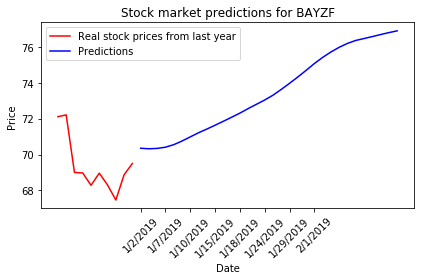

Epoch 1/10
2442/2442 [==============================] - 19s 8ms/step - loss: 0.0251
Epoch 2/10
2442/2442 [==============================] - 14s 6ms/step - loss: 0.0071
Epoch 3/10
2442/2442 [==============================] - 16s 7ms/step - loss: 0.0064
Epoch 4/10
2442/2442 [==============================] - 18s 7ms/step - loss: 0.0053
Epoch 5/10
2442/2442 [==============================] - 16s 6ms/step - loss: 0.0056
Epoch 6/10
2442/2442 [==============================] - 16s 7ms/step - loss: 0.0049
Epoch 7/10
2442/2442 [==============================] - 20s 8ms/step - loss: 0.0054
Epoch 8/10
2442/2442 [==============================] - 15s 6ms/step - loss: 0.0040
Epoch 9/10
2442/2442 [==============================] - 16s 7ms/step - loss: 0.0040
Epoch 10/10
2442/2442 [==============================] - 15s 6ms/step - loss: 0.0041


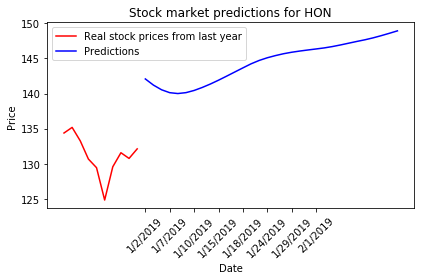

Epoch 1/10
2442/2442 [==============================] - 16s 7ms/step - loss: 0.0208
Epoch 2/10
2442/2442 [==============================] - 14s 6ms/step - loss: 0.0068
Epoch 3/10
2442/2442 [==============================] - 14s 6ms/step - loss: 0.0052
Epoch 4/10
2442/2442 [==============================] - 15s 6ms/step - loss: 0.0052
Epoch 5/10
2442/2442 [==============================] - 16s 7ms/step - loss: 0.0043
Epoch 6/10
2442/2442 [==============================] - 15s 6ms/step - loss: 0.0047
Epoch 7/10
2442/2442 [==============================] - 17s 7ms/step - loss: 0.0040
Epoch 8/10
2442/2442 [==============================] - 21s 9ms/step - loss: 0.0042
Epoch 9/10
2442/2442 [==============================] - 18s 7ms/step - loss: 0.0034
Epoch 10/10
2442/2442 [==============================] - 17s 7ms/step - loss: 0.0033


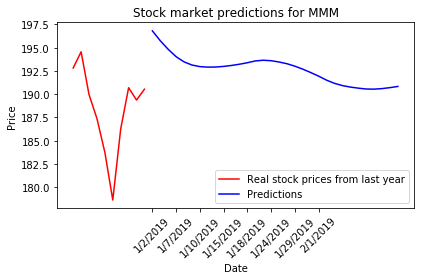

Epoch 1/10
1039/1039 [==============================] - 11s 10ms/step - loss: 0.0443
Epoch 2/10
1039/1039 [==============================] - 6s 6ms/step - loss: 0.0171
Epoch 3/10
1039/1039 [==============================] - 6s 6ms/step - loss: 0.0154
Epoch 4/10
1039/1039 [==============================] - 7s 7ms/step - loss: 0.0134
Epoch 5/10
1039/1039 [==============================] - 8s 8ms/step - loss: 0.0125
Epoch 6/10
1039/1039 [==============================] - 7s 7ms/step - loss: 0.0110
Epoch 7/10
1039/1039 [==============================] - 7s 6ms/step - loss: 0.0107
Epoch 8/10
1039/1039 [==============================] - 7s 7ms/step - loss: 0.0111
Epoch 9/10
1039/1039 [==============================] - 8s 7ms/step - loss: 0.0104
Epoch 10/10
1039/1039 [==============================] - 8s 8ms/step - loss: 0.0102


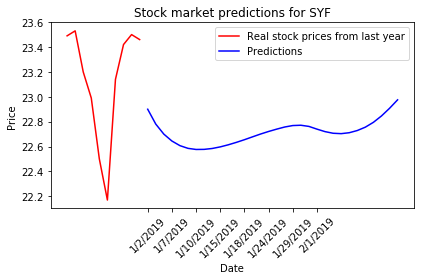

In [13]:
company_files = ['BAYZF.csv', 'HON.csv', 'MMM.csv', 'SYF.csv']

total_predictions = []
for fname in company_files:
    fpath = './Data Given/' + fname
    company = fname.split('.')[0]
    input_data, df_predict, predicted_stock_prices = get_2019_predictions(fpath)
    assert(len(predicted_stock_prices) == 32)
    plot_predictions(company, input_data, df_predict, predicted_stock_prices)
    total_predictions.extend(predicted_stock_prices)


In [14]:
df = pd.DataFrame({'Close price':total_predictions})
df.to_csv('Team50_Undergrad.csv', index=False)
pd.read_csv('Team50_Undergrad.csv')

,Close price
0,70.349639
1,70.319817
2,70.340591
3,70.407359
4,70.548836
5,70.751812
6,70.983990
7,71.214075
8,71.419649
9,71.634631


## Resources
https://www.quantinsti.com/blog/artificial-neural-network-python-using-keras-predicting-stock-price-movement?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html

